Epoch 0: Loss = 0.7063
Epoch 100: Loss = 0.6956
Epoch 200: Loss = 0.6936
Epoch 300: Loss = 0.6939
Epoch 400: Loss = 0.6948
Epoch 500: Loss = 0.6957
Epoch 600: Loss = 0.6965
Epoch 700: Loss = 0.6974
Epoch 800: Loss = 0.6985
Epoch 900: Loss = 0.6996

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4



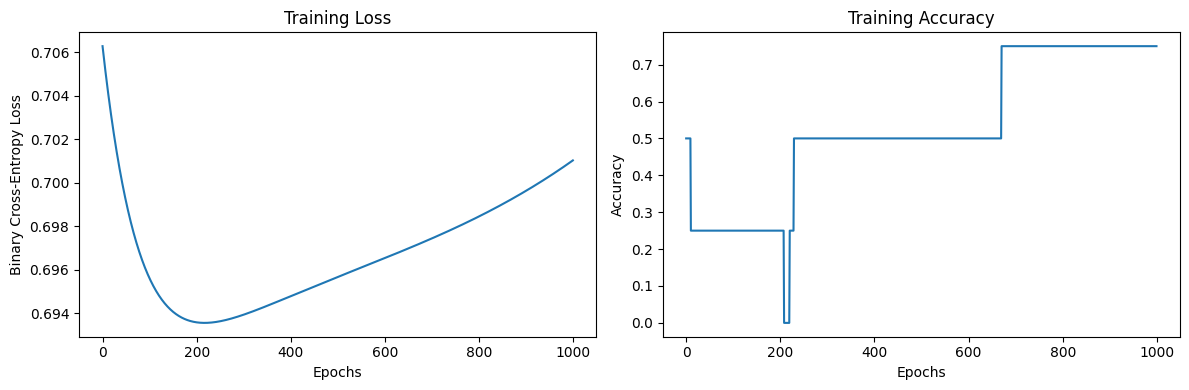

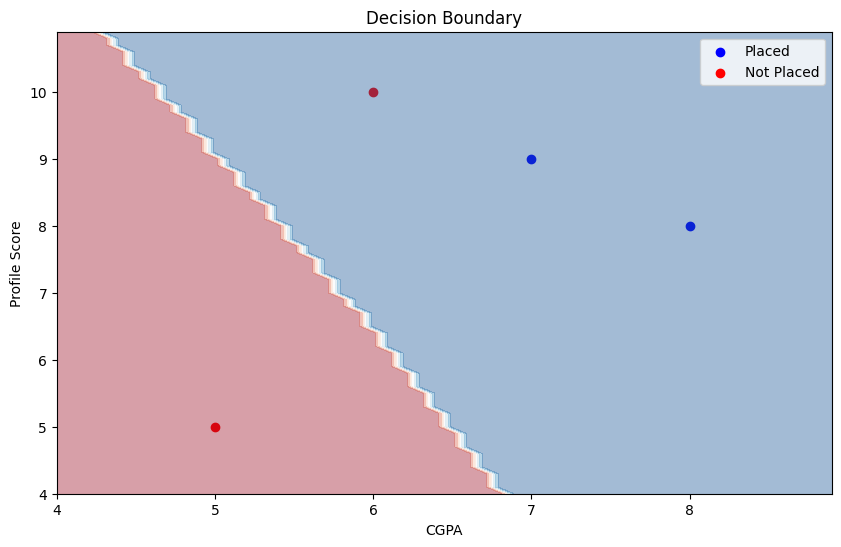

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

class BackpropagationClassifier:
    def __init__(self, layer_dims, learning_rate=0.001, epochs=1000):
        """
        Initialize neural network parameters

        Parameters:
        - layer_dims: List of layer dimensions [input_dim, hidden_dim1, ..., output_dim]
        - learning_rate: Step size for parameter updates
        - epochs: Number of training iterations
        """
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.parameters = {}
        self.history = {'loss': [], 'accuracy': []}

    def initialize_parameters(self):
        """Initialize weights and biases"""
        np.random.seed(42)
        L = len(self.layer_dims)

        for l in range(1, L):
            # Xavier/Glorot initialization
            self.parameters[f'W{l}'] = np.random.randn(self.layer_dims[l-1], self.layer_dims[l]) * np.sqrt(2 / (self.layer_dims[l-1] + self.layer_dims[l]))
            self.parameters[f'b{l}'] = np.zeros((self.layer_dims[l], 1))

    def sigmoid(self, Z):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-Z))

    def sigmoid_derivative(self, Z):
        """Derivative of sigmoid activation"""
        s = self.sigmoid(Z)
        return s * (1 - s)

    def forward_propagation(self, X):
        """Forward propagation through the network"""
        A = X.copy()
        cache = {'A0': A}

        L = len(self.layer_dims)
        for l in range(1, L):
            W = self.parameters[f'W{l}']
            b = self.parameters[f'b{l}']

            Z = np.dot(A, W) + b.T

            # Use sigmoid for hidden and output layers
            A = self.sigmoid(Z)

            cache[f'Z{l}'] = Z
            cache[f'A{l}'] = A

        return A, cache

    def compute_loss(self, y_pred, y_true):
        """Compute binary cross-entropy loss"""
        m = y_true.shape[0]
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss

    def backpropagation(self, X, y, cache):
        """Backpropagation algorithm for updating parameters"""
        m = X.shape[0]
        L = len(self.layer_dims)

        # Compute output layer gradient
        y_pred = cache[f'A{L-1}']
        dZ_output = y_pred - y.reshape(-1, 1)

        gradients = {}

        # Backpropagate through layers
        for l in range(L-1, 0, -1):
            A_prev = cache[f'A{l-1}']

            # Compute gradients for weights and biases
            dW = (1/m) * np.dot(A_prev.T, dZ_output)
            db = (1/m) * np.sum(dZ_output, axis=0, keepdims=True)

            # Prepare gradient for previous layer
            if l > 1:
                dZ_output = np.dot(dZ_output, self.parameters[f'W{l}'].T) * self.sigmoid_derivative(cache[f'Z{l-1}'])

            # Store gradients
            gradients[f'dW{l}'] = dW
            gradients[f'db{l}'] = db

        return gradients

    def update_parameters(self, gradients):
        """Update network parameters using gradient descent"""
        L = len(self.layer_dims)

        for l in range(1, L):
            self.parameters[f'W{l}'] -= self.learning_rate * gradients[f'dW{l}']
            self.parameters[f'b{l}'] -= self.learning_rate * gradients[f'db{l}'].T

    def train(self, X, y):
        """Train the neural network"""
        self.initialize_parameters()

        for epoch in range(self.epochs):
            # Forward propagation
            y_pred, cache = self.forward_propagation(X)

            # Compute loss
            loss = self.compute_loss(y_pred, y)

            # Backpropagation
            gradients = self.backpropagation(X, y, cache)

            # Update parameters
            self.update_parameters(gradients)

            # Track loss and accuracy
            self.history['loss'].append(loss)
            self.history['accuracy'].append(accuracy_score(y, (y_pred > 0.5).astype(int)))

            # Print progress
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.4f}")

        return self

    def predict(self, X):
        """Predict class labels"""
        y_pred, _ = self.forward_propagation(X)
        return (y_pred > 0.5).astype(int)

    def plot_training_history(self):
        """Plot training loss and accuracy"""
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.history['loss'])
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Binary Cross-Entropy Loss')

        plt.subplot(1, 2, 2)
        plt.plot(self.history['accuracy'])
        plt.title('Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        plt.tight_layout()
        plt.show()

# Prepare dataset
df = pd.DataFrame([
    [8, 8, 1],
    [7, 9, 1],
    [6, 10, 0],
    [5, 5, 0]
], columns=['cgpa', 'profile_score', 'placed'])

# Split features and target
X = df[['cgpa', 'profile_score']].values
y = df['placed'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train model
clf = BackpropagationClassifier(layer_dims=[2, 4, 1], learning_rate=0.01, epochs=1000)
clf.train(X_scaled, y)

# Predictions and evaluation
y_pred = clf.predict(X_scaled)
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Plot training history
clf.plot_training_history()

# Decision boundary visualization
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='blue', label='Placed')
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='red', label='Not Placed')

# Create mesh grid for decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict for mesh grid
Z = clf.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)
plt.xlabel('CGPA')
plt.ylabel('Profile Score')
plt.title('Decision Boundary')
plt.legend()
plt.show()